# Grid search for optimal variational parameter

### Configure Notebook <a name="configure"></a>

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-exclamation-circle" aria-hidden="true"></i>&nbsp; Important</b><br>
    <p style="color: black">
        Run the cell below to configure the notebook. 
    </p>
<div>
</div>
</div>

In [1]:
import copy
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from helper import df_to_latex, fig_path, set_figsize, tab_path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Import code from src
sys.path.insert(0, '../src/')
import vmc  # noqa

# Set plot and dataframe style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"
params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
         }
          
plt.rcParams.update(params)
plt.rc('text', usetex=True)

pd.set_option('display.max_columns', 50)

### ASHONIB and RWM

In [2]:
df = pd.read_csv("../data/grid_search_ashonib_rwm.csv")
df

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,1,1,3,1.771561,0.01,0.1,3.906039,0.080476,9.487808,3.906039,0.080476,9.487808,0.41885,20000,80000,80000,20000,0
1,2,1,3,1.771561,0.01,0.1,3.794924,0.073124,9.250317,3.794924,0.073124,9.250317,0.41625,20000,82000,82000,22000,0
2,3,1,3,1.610510,0.01,0.1,3.954713,0.078042,9.714956,3.954713,0.078042,9.714956,0.45780,20000,76000,76000,16000,0
3,4,1,3,1.771561,0.01,0.1,3.949598,0.075201,9.186569,3.949598,0.075201,9.186569,0.41580,20000,78000,78000,18000,0
4,5,1,3,1.771561,0.01,0.1,3.996087,0.081078,10.610477,3.996087,0.081078,10.610477,0.42145,20000,78000,78000,18000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,12,500,3,0.025937,0.01,1.0,1030.911446,13.477313,15077.481880,2.061823,13.477313,15077.481880,0.34820,20000,96000,96000,36000,0
636,13,500,3,0.025937,0.01,1.0,994.863783,16.019645,9611.412507,1.989728,16.019645,9611.412507,0.34740,20000,94000,94000,34000,0
637,14,500,3,0.012458,0.01,1.0,1025.265732,30.364188,79640.248542,2.050531,30.364188,79640.248542,0.67760,20000,110000,110000,50000,0
638,15,500,3,0.014641,0.01,1.0,698.390000,87.116558,107813.706622,1.396780,87.116558,107813.706622,0.52280,20000,80000,80000,20000,0


In [3]:
df2 = df.groupby(['nparticles', 'alpha'], as_index=False).mean()[["nparticles", "alpha", "scaled_energy", "scaled_std_error", "scaled_variance"]]
df2.rename(columns={'nparticles': 'N'}, inplace=True)
df2

,N,alpha,scaled_energy,scaled_std_error,scaled_variance
0,1,0.1,3.909978,0.077548,9.663706
1,1,0.2,2.173776,0.033887,1.838985
2,1,0.3,1.701978,0.017931,0.479998
3,1,0.4,1.538985,0.007207,0.085201
4,1,0.5,1.500000,0.000000,0.000000
5,1,0.6,1.527065,0.005742,0.050941
6,1,0.7,1.586574,0.011305,0.184507
7,1,0.8,1.671275,0.016852,0.372544
8,1,0.9,1.772586,0.021087,0.605233
9,1,1.0,1.886997,0.025583,0.851071


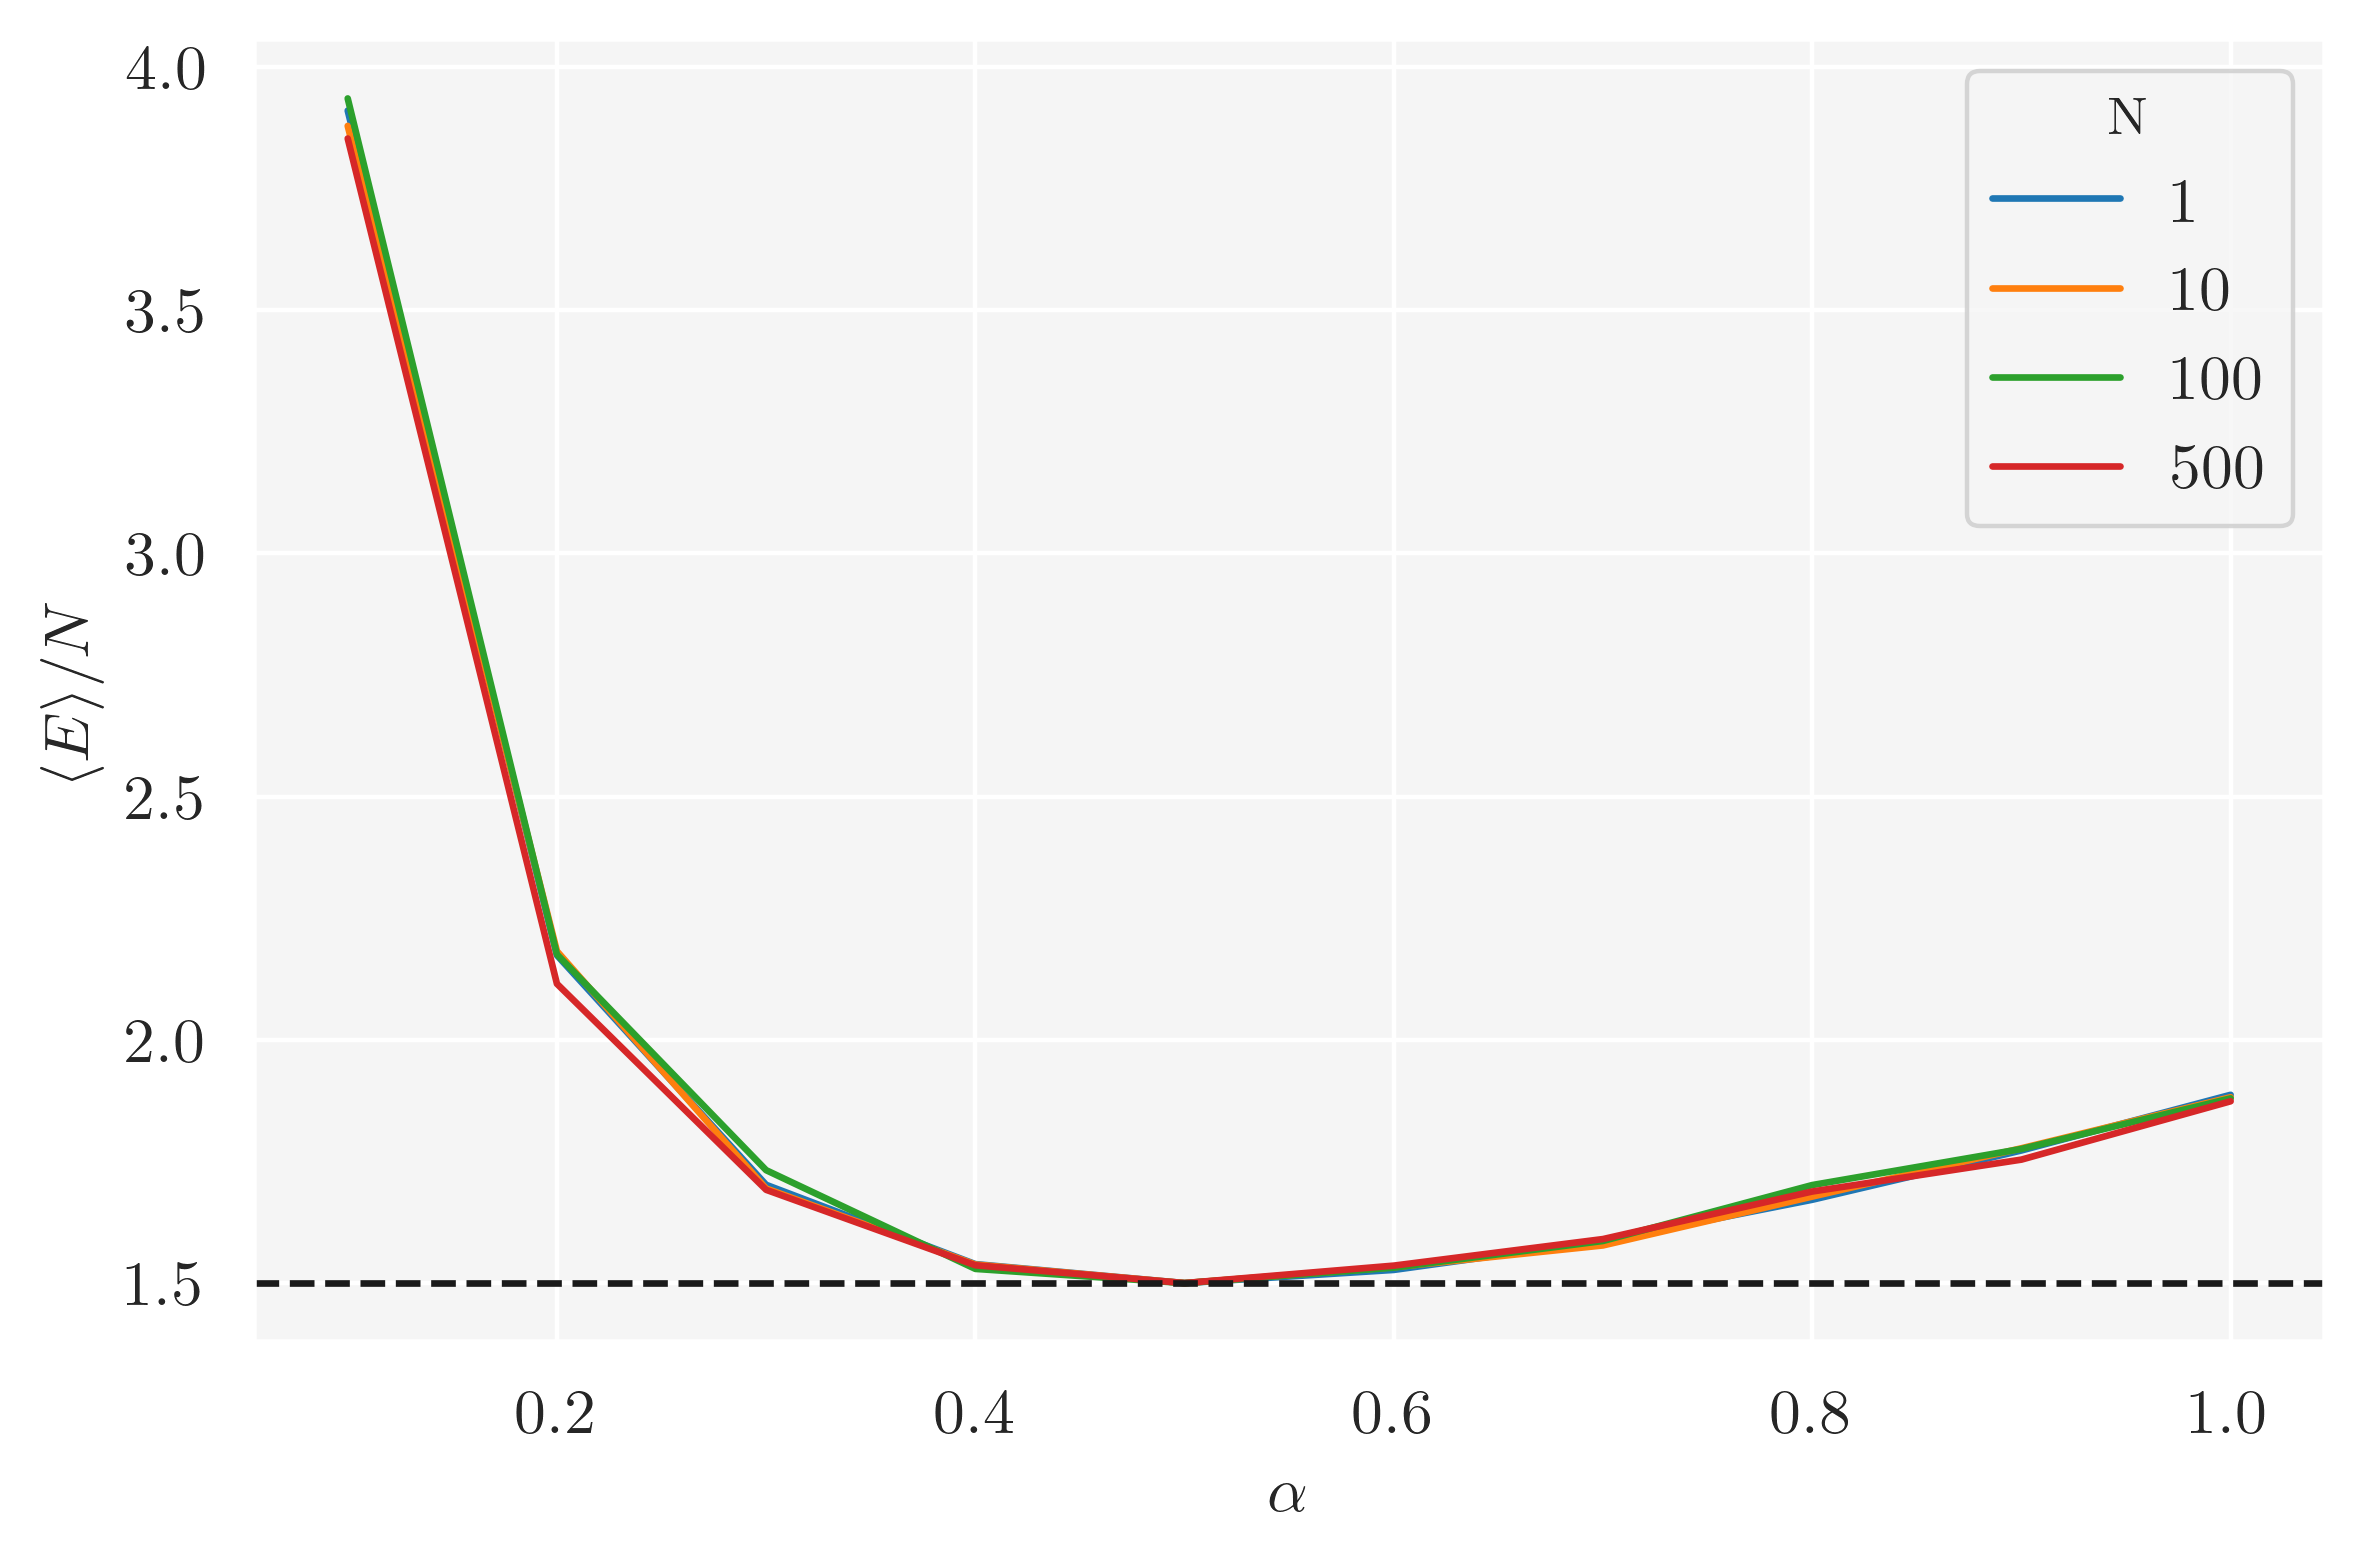

In [4]:
dim = 3
exact_energy = vmc.utils.exact_energy_scaled(dim)

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df2, 
             x="alpha", 
             y="scaled_energy", 
             hue="N", 
             palette="tab10",       
             ax=ax
            )
ax.axhline(exact_energy, ls='--', color='k', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\langle E \rangle / N$')
fig.savefig(fig_path("grid_search_ashonib_rwm_energy.pdf"), bbox_inches='tight')

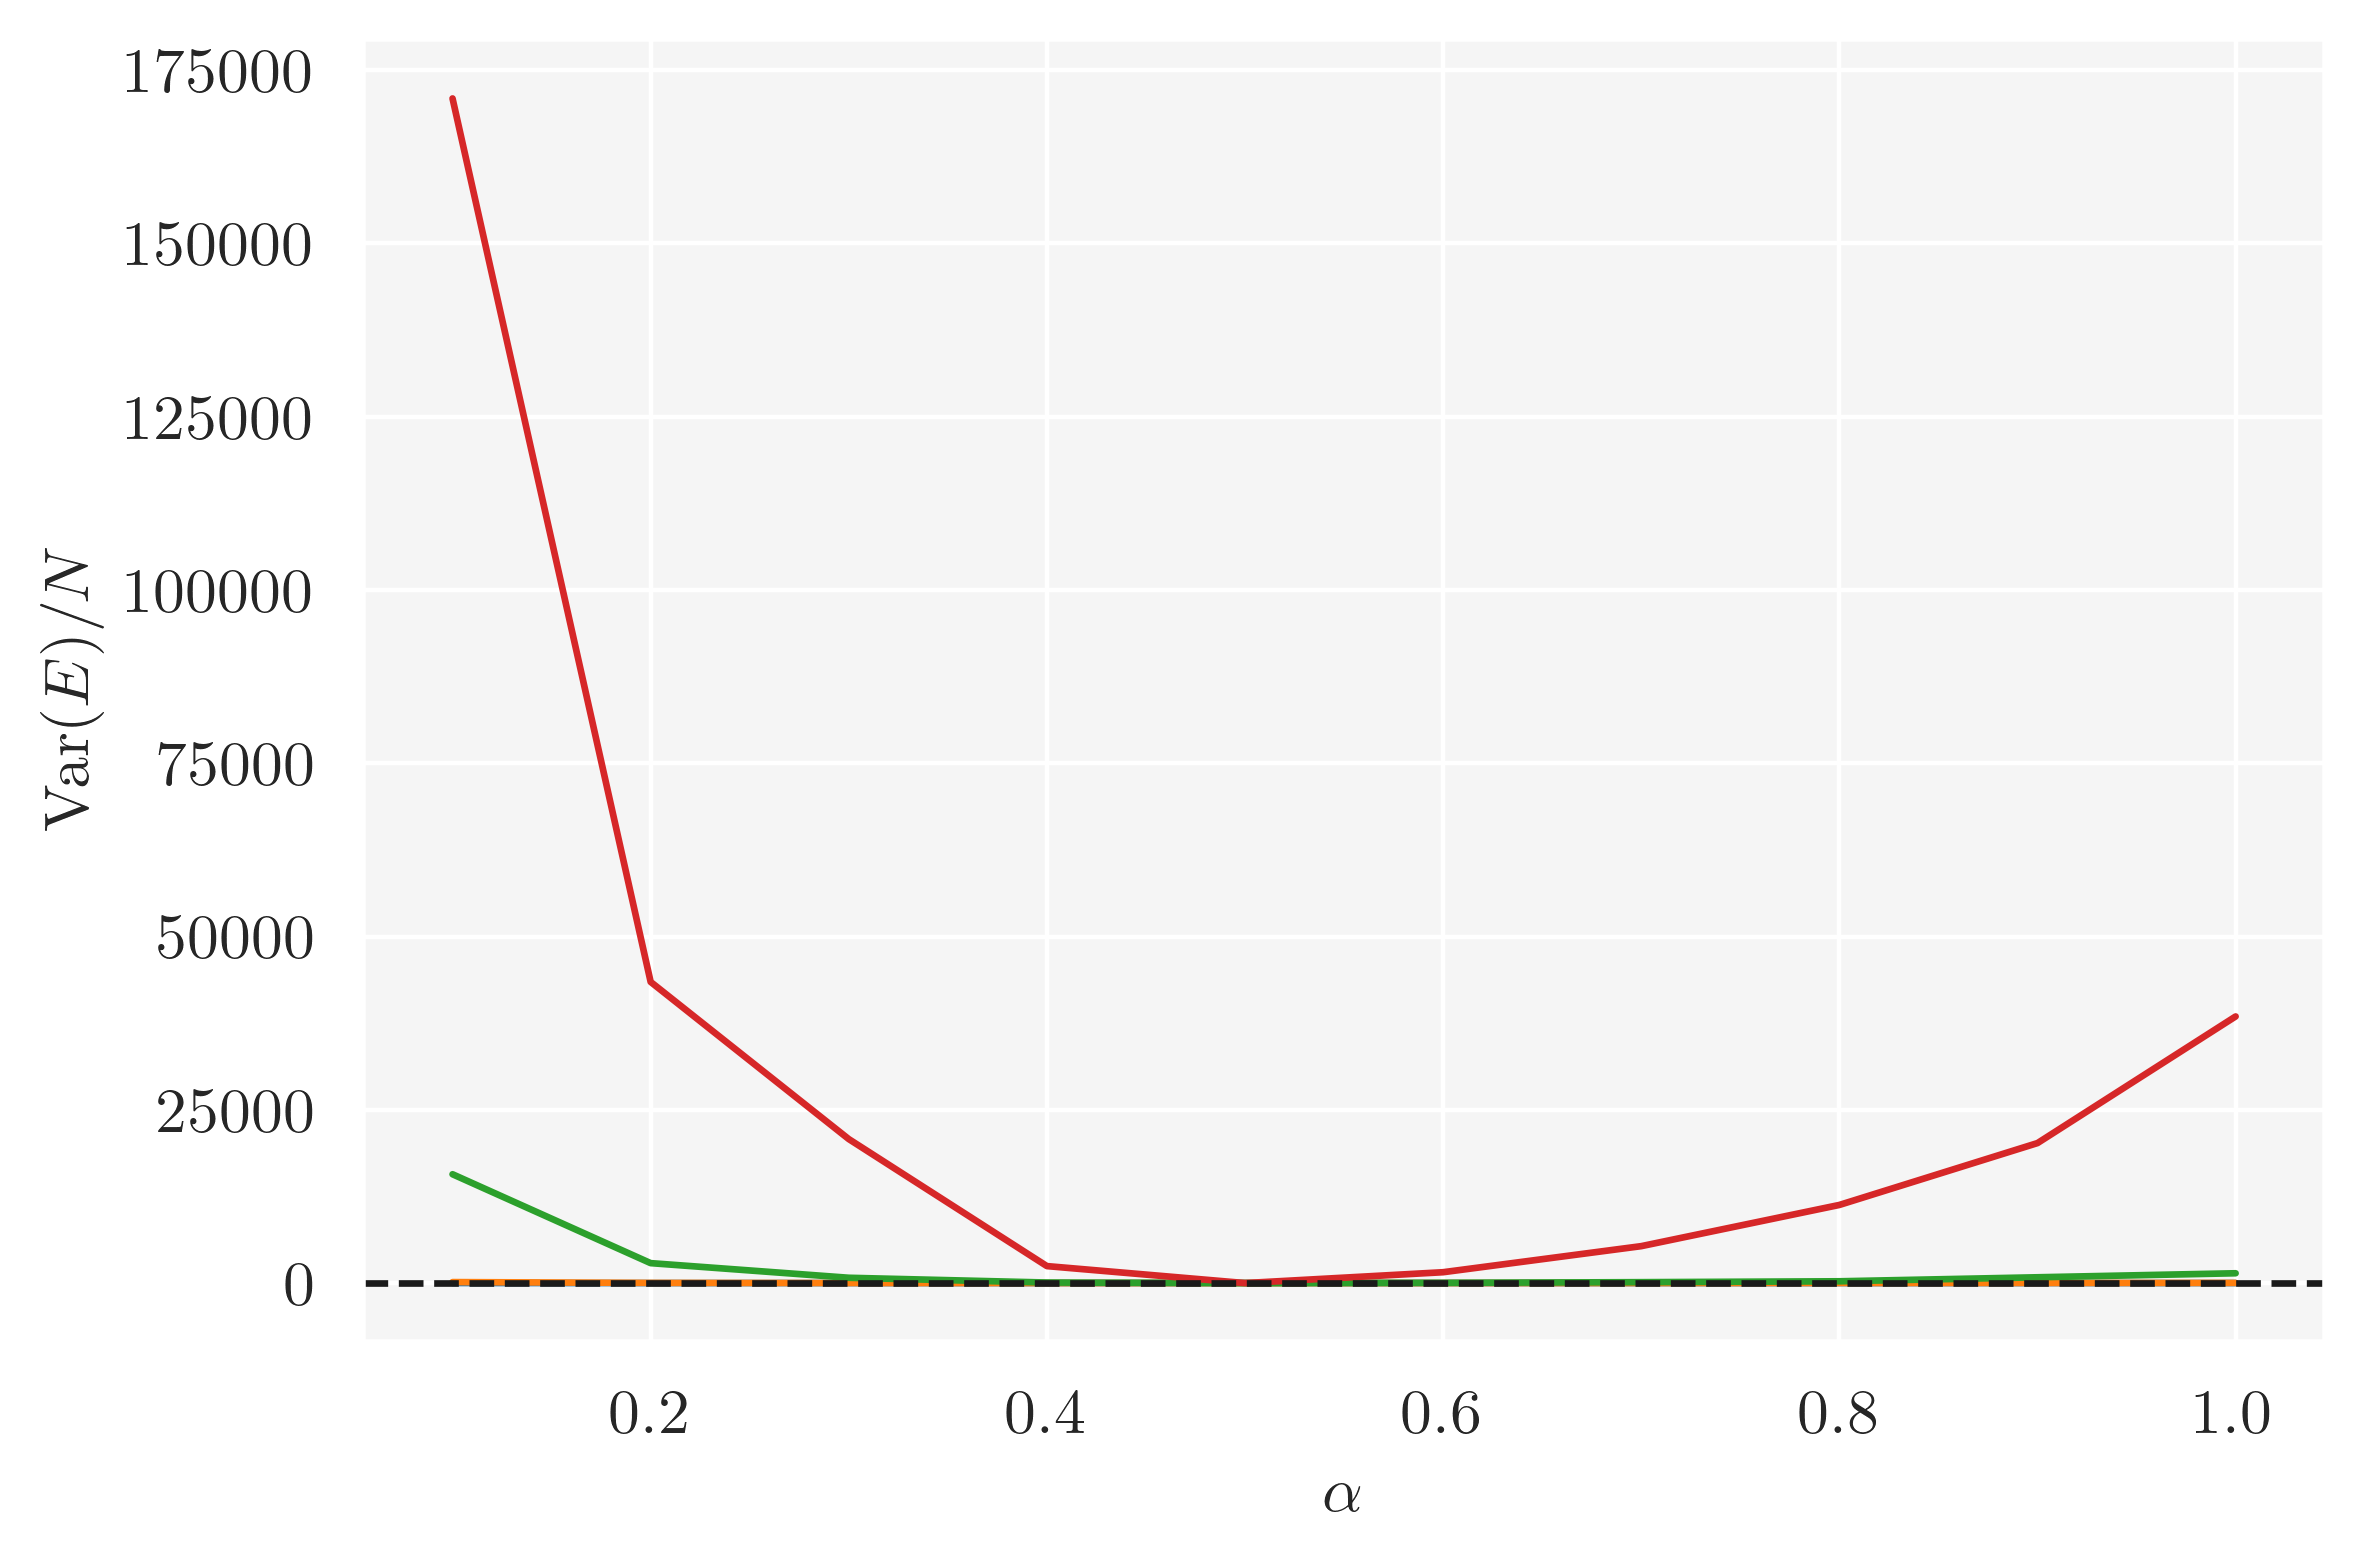

In [5]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df2, 
             x="alpha", 
             y="scaled_variance", 
             hue="N",
             palette="tab10", 
             ax=ax
            )
ax.axhline(0, ls='--', color='k', label='Ground truth')
ax.legend().set_visible(False)
ax.set(xlabel=r'$\alpha$', ylabel=r'$\mathrm{Var}(E)/N$')

fig.savefig(fig_path("grid_search_ashonib_rwm_variance.pdf"), bbox_inches='tight')

### SHONIB and RWM

In [6]:
df = pd.read_csv("../data/grid_search_shonib_rwm.csv")
df

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,1,1,3,1.771561,0.01,0.1,3.933350,0.083308,10.062337,3.933350,0.083308,10.062337,0.41765,20000,80000,80000,20000,0
1,2,1,3,1.771561,0.01,0.1,3.854974,0.090852,9.797721,3.854974,0.090852,9.797721,0.41805,20000,78000,78000,18000,0
2,3,1,3,1.771561,0.01,0.1,3.832163,0.072529,9.522220,3.832163,0.072529,9.522220,0.41640,20000,78000,78000,18000,0
3,4,1,3,1.771561,0.01,0.1,3.967976,0.076520,9.695282,3.967976,0.076520,9.695282,0.41665,20000,80000,80000,20000,0
4,5,1,3,1.771561,0.01,0.1,3.919678,0.069710,9.319818,3.919678,0.069710,9.319818,0.42255,20000,78000,78000,18000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,12,500,3,0.009550,0.01,1.0,1248.655525,40.197146,23467.961051,2.497311,40.197146,23467.961051,0.80870,20000,100000,100000,40000,0
636,13,500,3,0.017716,0.01,1.0,1015.601778,20.973652,16195.924908,2.031204,20.973652,16195.924908,0.52315,20000,82000,82000,22000,0
637,14,500,3,0.023579,0.01,1.0,900.392352,26.759305,32107.008123,1.800785,26.759305,32107.008123,0.43945,20000,88000,88000,28000,0
638,15,500,3,0.025678,0.01,1.0,1022.239740,33.260034,17083.813879,2.044479,33.260034,17083.813879,0.34580,20000,100000,100000,40000,0


In [7]:
df2 = df.groupby(['nparticles', 'alpha'], as_index=False).mean()[["nparticles", "alpha", "scaled_energy", "scaled_std_error", "scaled_variance"]]
df2.rename(columns={'nparticles': 'N'}, inplace=True)
df2

,N,alpha,scaled_energy,scaled_std_error,scaled_variance
0,1,0.1,3.915728,0.077554,9.780107
1,1,0.2,2.185689,0.033953,1.848162
2,1,0.3,1.700723,0.017516,0.477170
3,1,0.4,1.536993,0.007285,0.082559
4,1,0.5,1.500000,0.000000,0.000000
5,1,0.6,1.526336,0.005931,0.051843
6,1,0.7,1.587805,0.011165,0.180733
7,1,0.8,1.678747,0.016182,0.355277
8,1,0.9,1.768064,0.021220,0.596408
9,1,1.0,1.887172,0.025935,0.864791


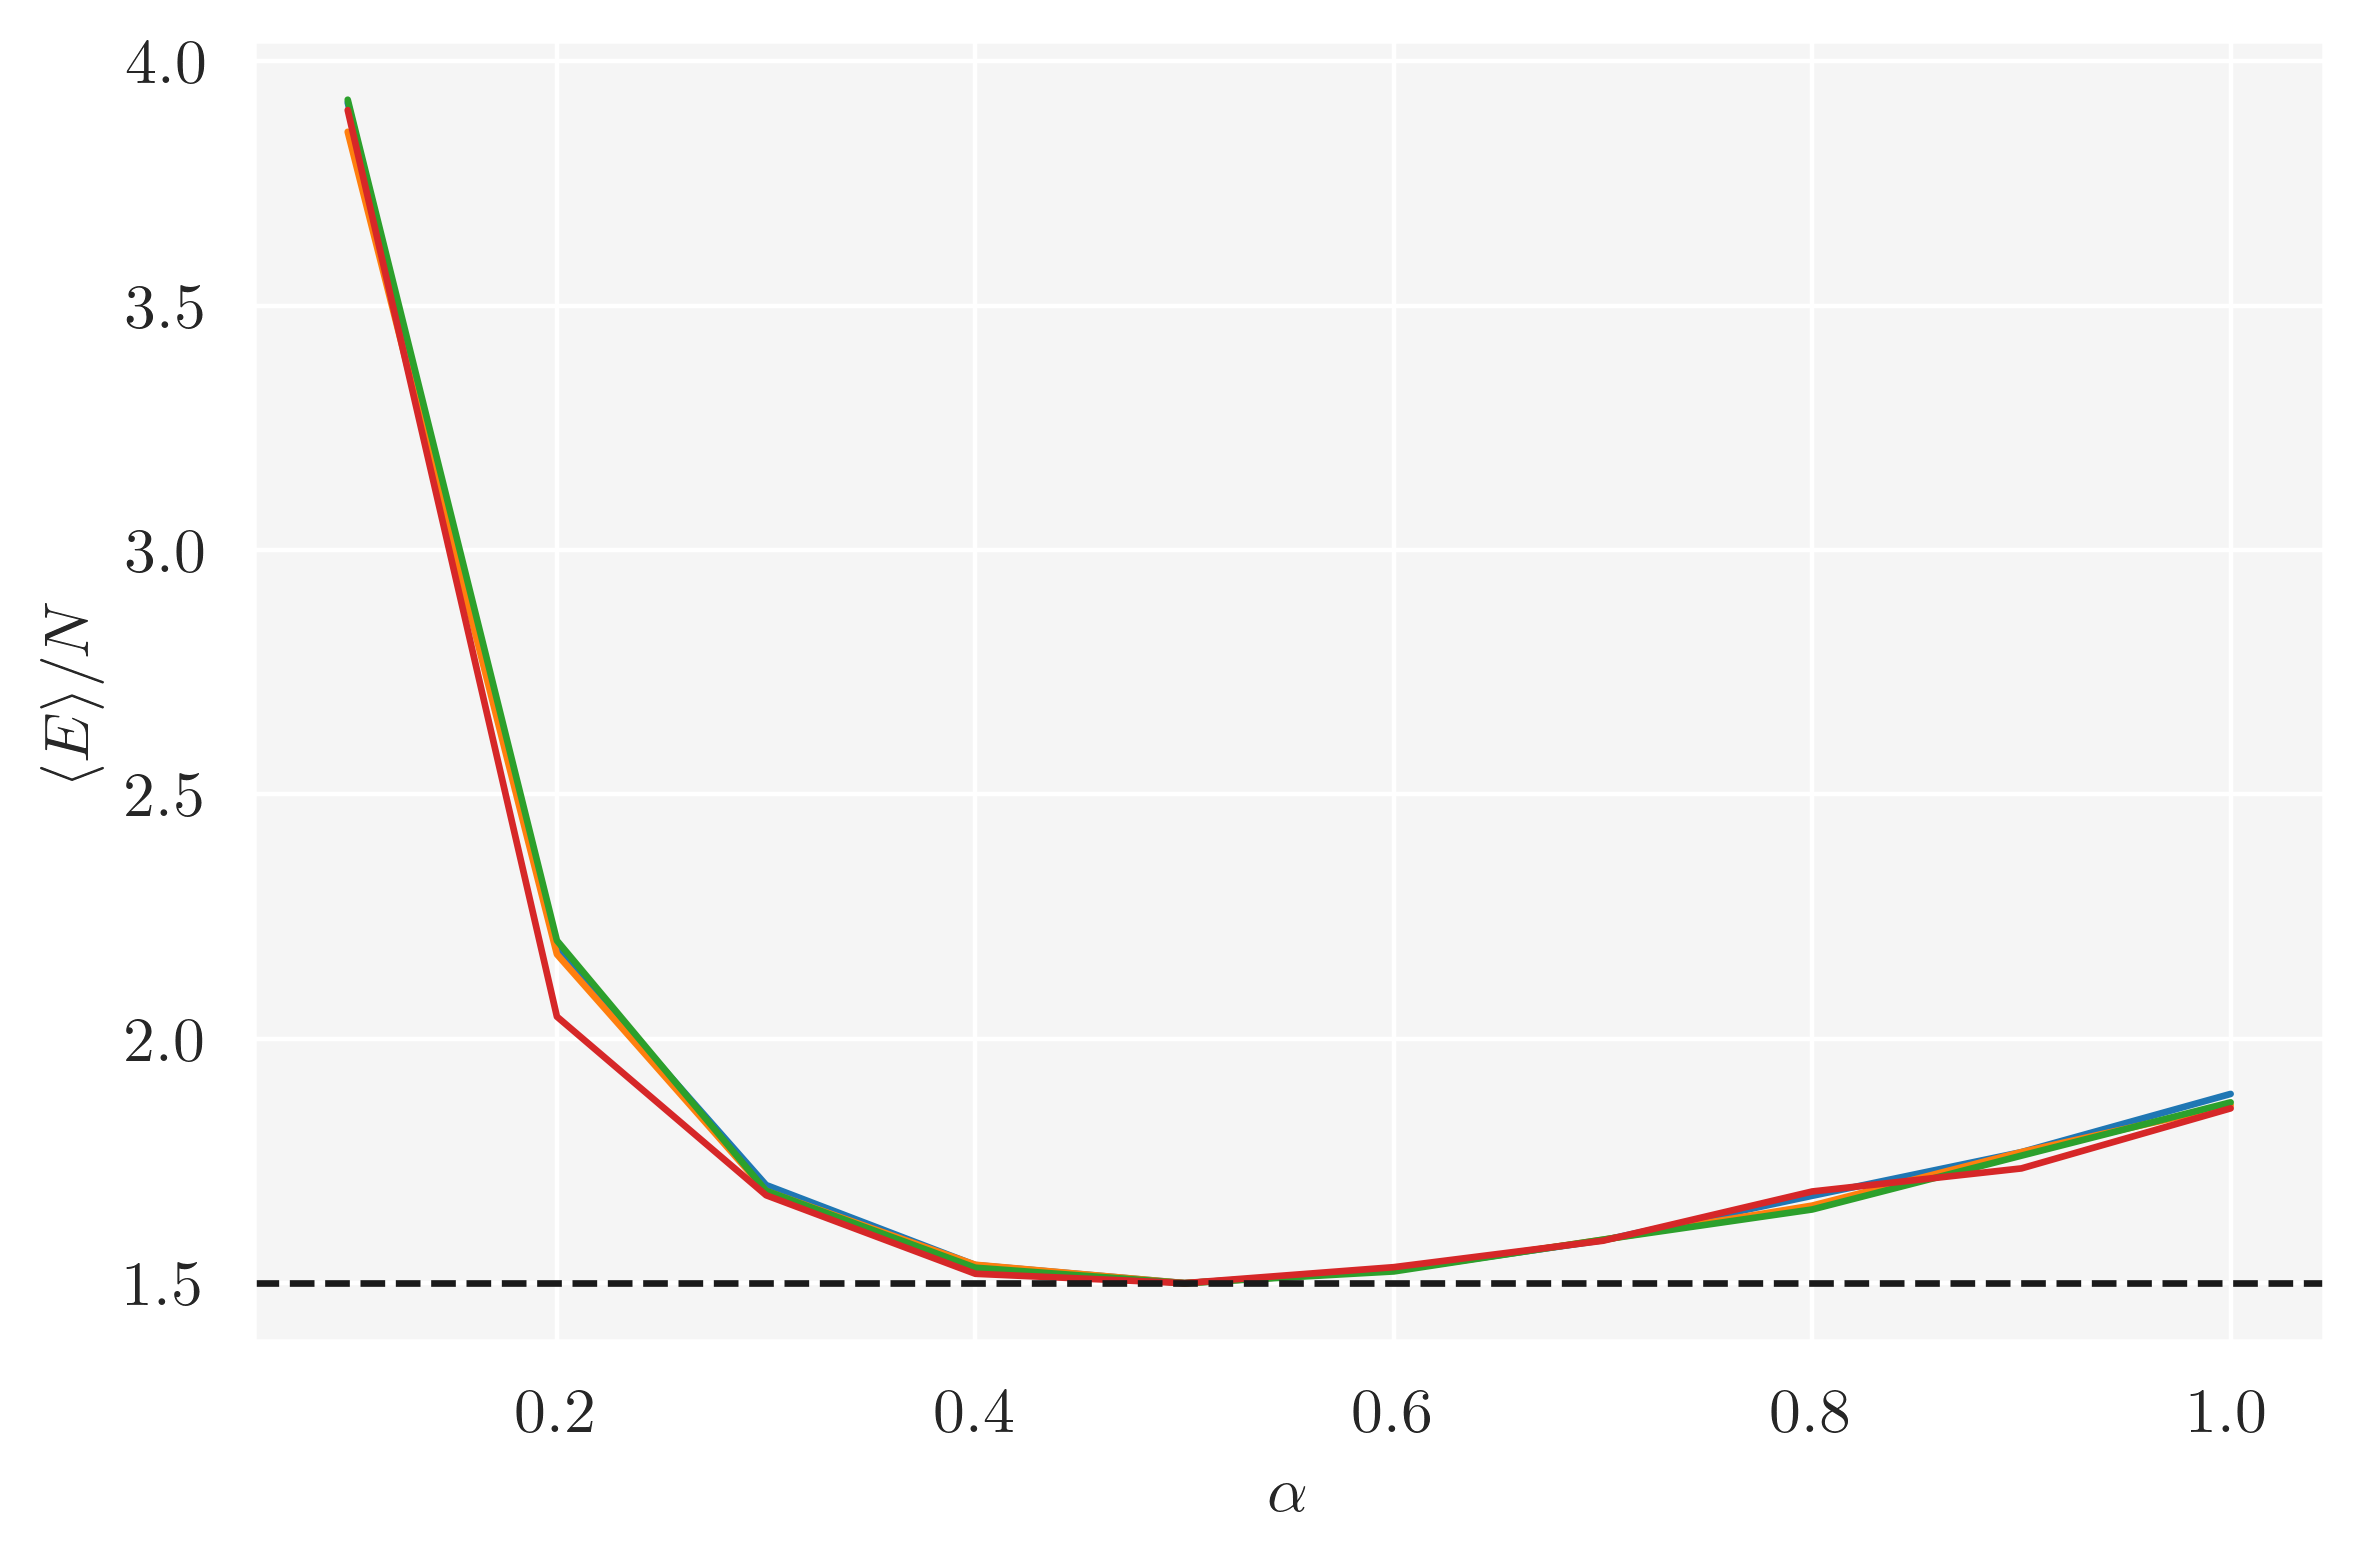

In [8]:
dim = 3
exact_energy = vmc.utils.exact_energy_scaled(dim)

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df2, 
             x="alpha", 
             y="scaled_energy", 
             hue="N", 
             palette="tab10",       
             ax=ax
            )
ax.axhline(exact_energy, ls='--', color='k', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\langle E \rangle / N$')
ax.legend().set_visible(False)

fig.savefig(fig_path("grid_search_shonib_rwm_energy.pdf"), bbox_inches='tight')

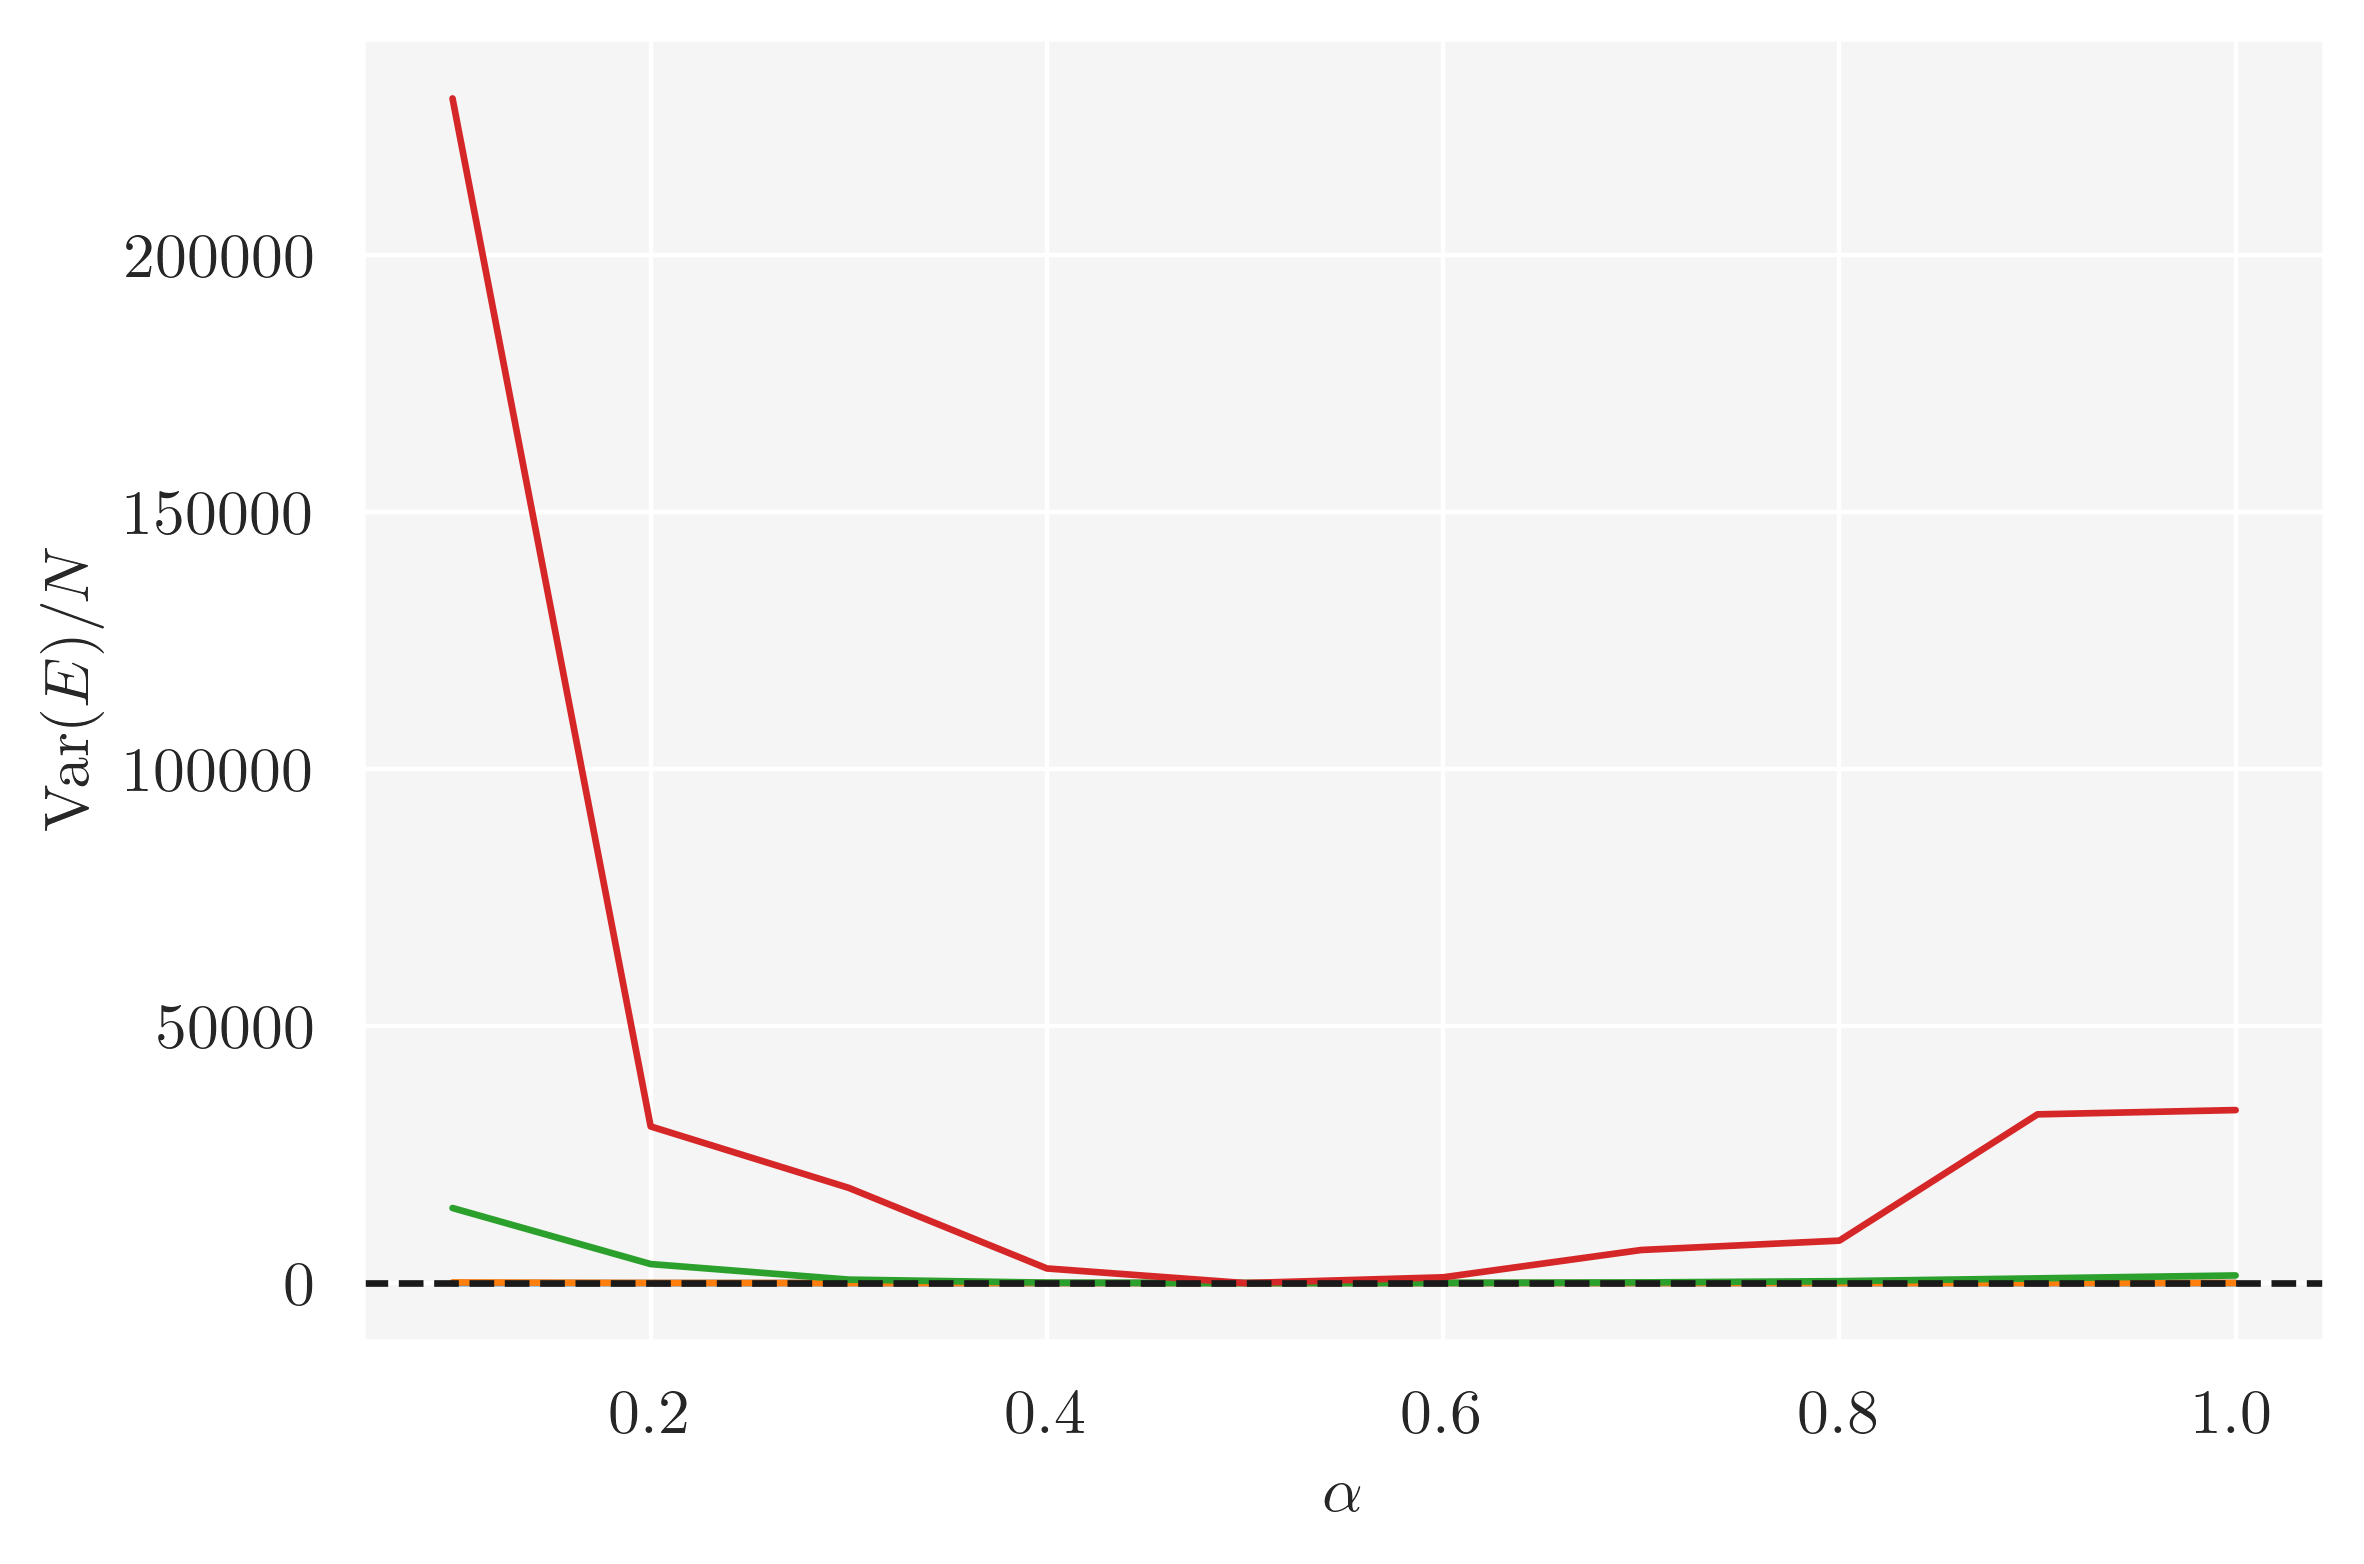

In [9]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)

sns.lineplot(data=df2, 
             x="alpha", 
             y="scaled_variance", 
             hue="N",
             palette="tab10", 
             ax=ax
            )
ax.axhline(0, ls='--', color='k', label='Ground truth')
ax.legend().set_visible(False)
ax.set(xlabel=r'$\alpha$', ylabel=r'$\mathrm{Var}(E)/N$')

fig.savefig(fig_path("grid_search_shonib_rwm_variance.pdf"), bbox_inches='tight')